In [339]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql.functions import col, round, lit, avg, count, max, when, first
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

In [340]:
spark = SparkSession.builder.appName('project').getOrCreate()

In [341]:
df = spark.read.csv("datasets/jobs_in_data.csv", header=True, inferSchema=True)

In [342]:
df.show()

+---------+--------------------+--------------------+---------------+------+-------------+------------------+----------------+---------------+------------+----------------+------------+
|work_year|           job_title|        job_category|salary_currency|salary|salary_in_usd|employee_residence|experience_level|employment_type|work_setting|company_location|company_size|
+---------+--------------------+--------------------+---------------+------+-------------+------------------+----------------+---------------+------------+----------------+------------+
|     2023|Data DevOps Engineer|    Data Engineering|            EUR| 88000|        95012|           Germany|       Mid-level|      Full-time|      Hybrid|         Germany|           L|
|     2023|      Data Architect|Data Architecture...|            USD|186000|       186000|     United States|          Senior|      Full-time|   In-person|   United States|           M|
|     2023|      Data Architect|Data Architecture...|            USD| 

In [343]:
df.count()

9355

In [344]:
df.printSchema()

root
 |-- work_year: integer (nullable = true)
 |-- job_title: string (nullable = true)
 |-- job_category: string (nullable = true)
 |-- salary_currency: string (nullable = true)
 |-- salary: integer (nullable = true)
 |-- salary_in_usd: integer (nullable = true)
 |-- employee_residence: string (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- employment_type: string (nullable = true)
 |-- work_setting: string (nullable = true)
 |-- company_location: string (nullable = true)
 |-- company_size: string (nullable = true)



In [345]:
df = df.drop('salary', 'salary_currency', 'job_title')

In [346]:
df_job_category = df.groupby('job_category').agg(avg('salary_in_usd').alias('avg')).orderBy('avg')

In [347]:
df_job_category_pd = df_job_category.toPandas()

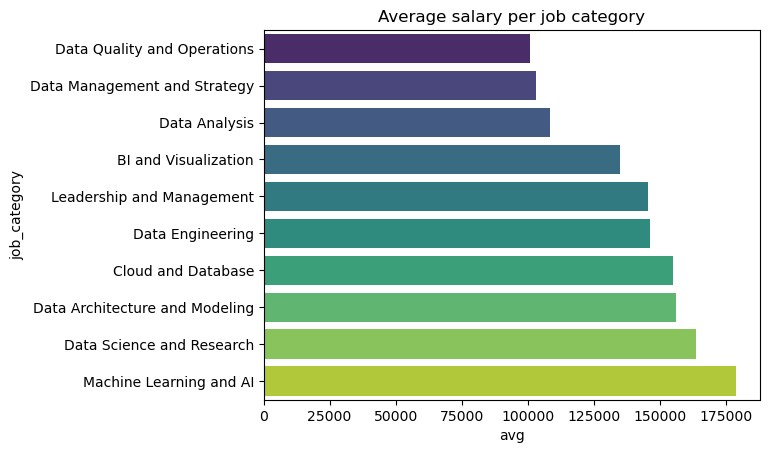

In [348]:
sns.barplot(x='avg', y='job_category', data=df_job_category_pd, palette='viridis', hue='job_category')
plt.title('Average salary per job category')
plt.show()

In [349]:
df_job_category_year = df.groupby('job_category', 'work_year').agg(avg('salary_in_usd').alias('avg'))
df_job_category_year.show()

+--------------------+---------+------------------+
|        job_category|work_year|               avg|
+--------------------+---------+------------------+
|  Cloud and Database|     2023|141666.66666666666|
|Leadership and Ma...|     2023|147428.22946859902|
|Data Quality and ...|     2023|105374.90697674418|
|       Data Analysis|     2021|           87818.5|
|Data Management a...|     2023|        99130.0625|
|    Data Engineering|     2021|107192.28888888888|
|Data Quality and ...|     2022| 84770.83333333333|
|Machine Learning ...|     2022|144289.06451612903|
|Data Management a...|     2022|114024.41666666667|
|Data Architecture...|     2021|          169940.6|
|Data Architecture...|     2022|166091.54347826086|
|Machine Learning ...|     2023|187266.85774058578|
|Data Science and ...|     2023|170078.13593037712|
|Leadership and Ma...|     2021|131892.88888888888|
|Data Architecture...|     2023|153436.04326923078|
|Data Science and ...|     2022|        143343.794|
|    Data En

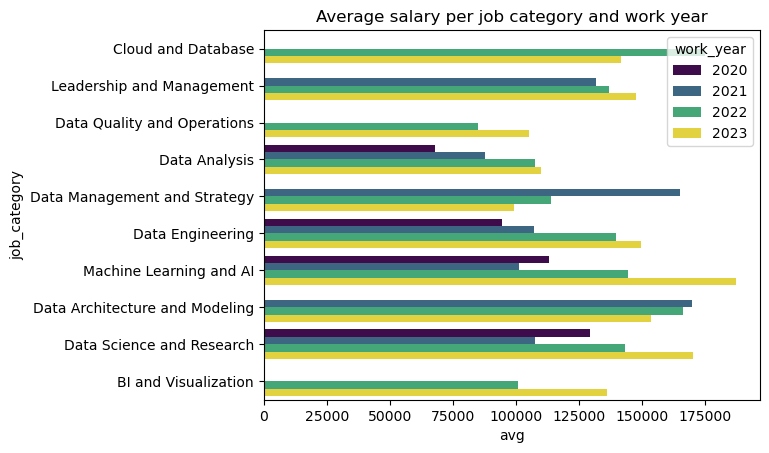

In [350]:
sns.barplot(x='avg', y='job_category', hue='work_year', data=df_job_category_year.toPandas(), palette='viridis')
plt.title('Average salary per job category and work year')
plt.show()

In [351]:
df_salary_avg_year = df.groupby('work_year').agg(avg('salary_in_usd').alias('average_salary'))

<Axes: xlabel='work_year', ylabel='average_salary'>

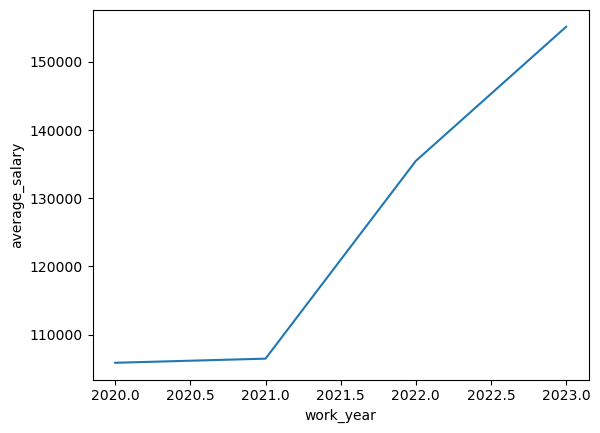

In [352]:
sns.lineplot(x='work_year', y='average_salary', data=df_salary_avg_year.toPandas())

<Axes: xlabel='salary_in_usd', ylabel='experience_level'>

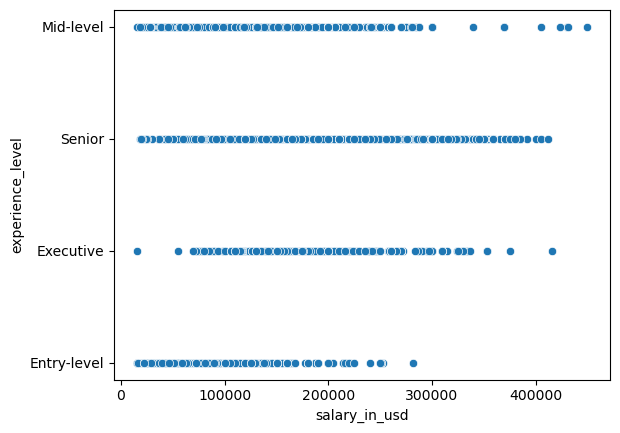

In [353]:
sns.scatterplot(x='salary_in_usd', y='experience_level', data=df.toPandas())

<Axes: xlabel='company_size', ylabel='salary_in_usd'>

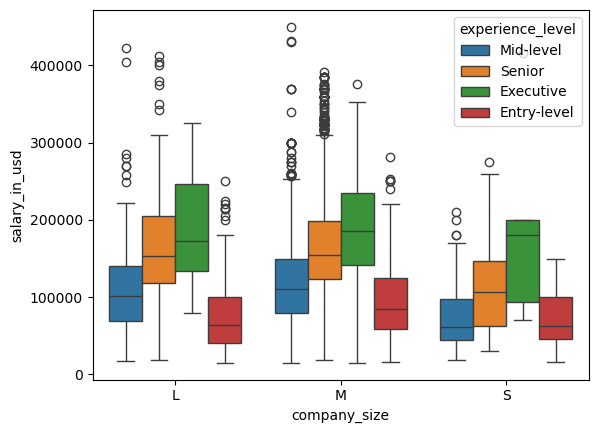

In [354]:
sns.boxplot(x='company_size', y='salary_in_usd', hue='experience_level', data=df.toPandas())

<Axes: xlabel='salary_in_usd', ylabel='job_category'>

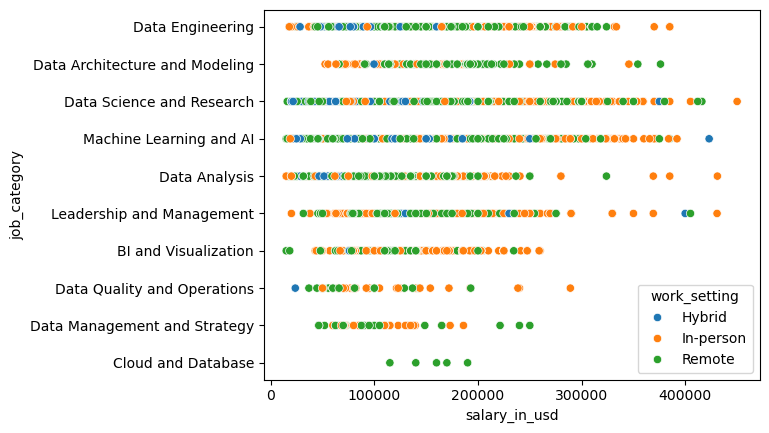

In [355]:
sns.scatterplot(x='salary_in_usd', y='job_category', hue='work_setting', data=df.toPandas())

In [356]:
url = 'https://wisevoter.com/country-rankings/cost-of-living-by-country/'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

In [357]:
table = soup.find('table', {'class': 'shdb-on-page-table'})
rows = table.find_all('tr')

In [358]:
data = []
schema = [column.text.strip() for column in rows[0].find_all('th')]
schema = StructType([
    StructField(schema[0], StringType(), True),
    StructField(schema[1], StringType(), True),
    StructField(schema[2], FloatType(), True),
    StructField('Percentage Change vs 2022', FloatType(), True),    
])
x = 0
for row in rows[1:]:
    columns = row.find_all('td')
    columns = [column.text.strip() for column in columns]
    values = []
    for column in columns:
        x = 1 if x==4 else x+1
        if x == 3:
            column = float(column.replace('$', '').replace(',', ''))
        if x == 4:
            column = column.replace('%', '').replace('.', '')
            column = float(column)/100 if column else None
        values.append(column)
    data.append(values)
df_costs = spark.createDataFrame(data, schema=schema)

In [359]:
df_costs = df_costs.withColumn('Percentage Change vs 2022', round(col('Cost of Living (2023)')/(col('Percentage Change vs 2022')/100  + 1),2)).withColumnRenamed('Percentage Change vs 2022', 'Cost of Living (2022)')

In [360]:
df_costs.show()

+---+--------------------+---------------------+---------------------+
|  #|             Country|Cost of Living (2023)|Cost of Living (2022)|
+---+--------------------+---------------------+---------------------+
|  1|              Monaco|               3955.0|              3585.03|
|  2|           Singapore|               3408.0|              2419.94|
|  3|      Cayman Islands|               3255.0|              2887.94|
|  4|         Switzerland|               2850.0|              2507.04|
|  5|             Iceland|               2457.0|               2054.0|
|  6|             Ireland|               2343.0|              1974.05|
|  7|       Liechtenstein|               2326.0|              2118.01|
|  8|United States of ...|               2317.0|              2111.93|
|  9|          Luxembourg|               2271.0|              2050.01|
| 10|           Australia|               2212.0|              1947.01|
| 11|      United Kingdom|               2017.0|              1803.95|
| 12| 

In [361]:
df_costs_2023 = df_costs[['Country','Cost of Living (2023)']].withColumn('year', lit('2023'))
df_costs_2022 = df_costs[['Country','Cost of Living (2022)']].withColumn('year', lit('2022'))

In [362]:
df_costs = df_costs_2023.union(df_costs_2022).withColumnRenamed('Cost of Living (2023)', 'Cost of Living')

In [363]:
df_costs = df_costs.withColumn('Country', when(df_costs['Country']=='United States of America', 'United States').otherwise(df_costs['Country']))

In [368]:
df_costs.show()

+--------------------+--------------+----+
|             Country|Cost of Living|year|
+--------------------+--------------+----+
|              Monaco|        3955.0|2023|
|           Singapore|        3408.0|2023|
|      Cayman Islands|        3255.0|2023|
|         Switzerland|        2850.0|2023|
|             Iceland|        2457.0|2023|
|             Ireland|        2343.0|2023|
|       Liechtenstein|        2326.0|2023|
|       United States|        2317.0|2023|
|          Luxembourg|        2271.0|2023|
|           Australia|        2212.0|2023|
|      United Kingdom|        2017.0|2023|
|             Vanuatu|        2010.0|2023|
|              Norway|        1964.0|2023|
|               Qatar|        1939.0|2023|
|             Denmark|        1922.0|2023|
|              Canada|        1901.0|2023|
|         New Zealand|        1876.0|2023|
|         Netherlands|        1862.0|2023|
|              Israel|        1707.0|2023|
|United Arab Emirates|        1680.0|2023|
+----------

In [364]:
df_jobs_w_costs = df.join(df_costs, on=(col('employee_residence') == col('Country')) & (col('work_year') == col('year')))

In [365]:
df_jobs_w_costs = df_jobs_w_costs.withColumn('Cost of Living', 12*col('Cost of Living'))
df_jobs_w_costs = df_jobs_w_costs.withColumn('salary_remainder_ratio', round(100*(col('salary_in_usd') - col('Cost of Living'))/col('salary_in_usd'),2))

In [366]:
df_count_er = df_jobs_w_costs.groupBy('employee_residence').agg(count('employee_residence').alias('count'))
df_employee_residence_cost = df_jobs_w_costs.join(df_count_er, 'employee_residence').filter(col('count')>10)
df_employee_residence_cost = df_employee_residence_cost.groupby('employee_residence', 'work_setting').agg(avg('salary_remainder_ratio'))

<Axes: xlabel='avg(salary_remainder_ratio)', ylabel='employee_residence'>

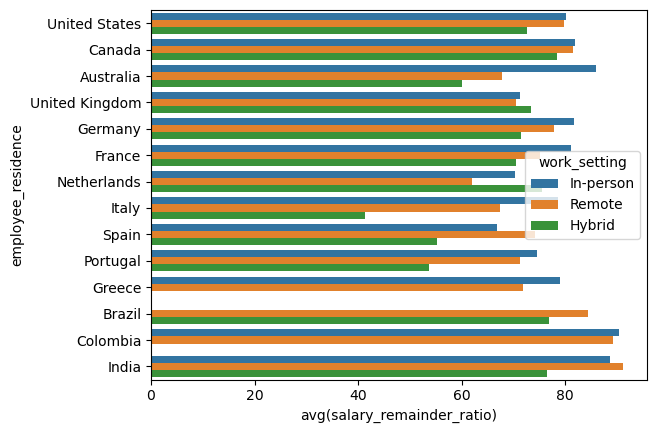

In [367]:
sns.barplot(x='avg(salary_remainder_ratio)', y='employee_residence', hue='work_setting', data=df_employee_residence_cost.toPandas())